# Determine what the FlyBase files are

I have identified a set of ~5k high quality samples to send to FlyBase. I want to verify what they are while files finish running.

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition.pca import PCA
from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs
from ncbi_remap.normalization import cpm

# Setup notebook
nbconfig = Nb.setup_notebook()

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

last updated: 2017-12-15 
Git hash: e8b461e4623cb168ee15bba032c8be008bcc76e9


In [2]:
# Load database
with open('../output/.mongodb_host') as fh:
    host = fh.read().strip()

client = MongoClient(host=host, port=27022)
db = client['sra2']
bio = db['biometa']
ncbi = db['ncbi']
remap = db['remap']

In [3]:
# Get list of FlyBase Samples
fb = pd.read_csv('../output/flybase_samples.tsv', sep='\t')

In [63]:
# Load library_strategy
dat = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            #'_id': {
            #    '$in': fb.srx.unique().tolist()
            #}
            'sra.experiment.library_strategy': {'$exists': 1}
        }
    },
    {
        '$project': {
            'srx': '$srx',
            '_id': 0,
            'library_strategy': '$sra.experiment.library_strategy'
        }
    }
])))

dat.library_strategy.value_counts()

RNA-Seq                   11804
OTHER                      6822
WGS                        3737
ChIP-Seq                   3474
AMPLICON                    441
EST                         408
miRNA-Seq                   275
ncRNA-Seq                   231
MNase-Seq                   151
RIP-Seq                     121
SELEX                        32
DNase-Hypersensitivity       23
FAIRE-seq                    19
CLONEEND                     18
Bisulfite-Seq                17
FL-cDNA                      13
POOLCLONE                     8
WGA                           7
MeDIP-Seq                     6
Synthetic-Long-Read           6
CLONE                         4
Name: library_strategy, dtype: int64

In [5]:
# Import coverage count
srxs = fb.srx.unique().tolist()
dfs = []
for srx in srxs:
    cnts = store.select('prealn/workflow/feature_counts/counts', 'srx == srx')
    _cnt = cnts.unstack().sum()
    _cnt.name = srx
    dfs.append(_cnt)

df = pd.concat(dfs, axis=1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/data/fearjm/miniconda3/envs/ncbi_remap2/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-348307bdf5e7>", line 5, in <module>
    cnts = store.select('prealn/workflow/feature_counts/counts', 'srx == srx')
  File "/data/fearjm/miniconda3/envs/ncbi_remap2/lib/python3.6/site-packages/pandas/io/pytables.py", line 717, in select
    return it.get_result()
  File "/data/fearjm/miniconda3/envs/ncbi_remap2/lib/python3.6/site-packages/pandas/io/pytables.py", line 1457, in get_result
    results = self.func(self.start, self.stop, where)
  File "/data/fearjm/miniconda3/envs/ncbi_remap2/lib/python3.6/site-packages/pandas/io/pytables.py", line 710, in func
    columns=columns, **kwargs)
  File "/data/fearjm/miniconda3/envs/ncbi_remap2/lib/python3.6/site-packages/pandas/io/pytables.py", line 4219, in read
    s = super(AppendableSeriesTable, s

KeyboardInterrupt: 

In [ ]:
# Normalize coverage counts and try standard scalter
norm = cpm(df)
scaler = StandardScaler()
X = scaler.fit_transform(norm.T)

In [69]:
# deminsionality reduction what is the variance like
pca = PCA()
X_pca = pca.fit_transform(X)

fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=20, azim=40)
ax.scatter(pcs[:, 0], pcs[:, 1], pcs[:, 2])

In [139]:
# How many components
def _pca(X, n_components=10):
    pca = PCA(n_components=n_components).fit(X)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(pca.explained_variance_ratio_)
    ax1.scatter(np.arange(n_components), pca.explained_variance_ratio_)
    ax2.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.suptitle(f'{n_components} Components')
    plt.tight_layout(rect=[0, 0, 1, .95])
    return pca

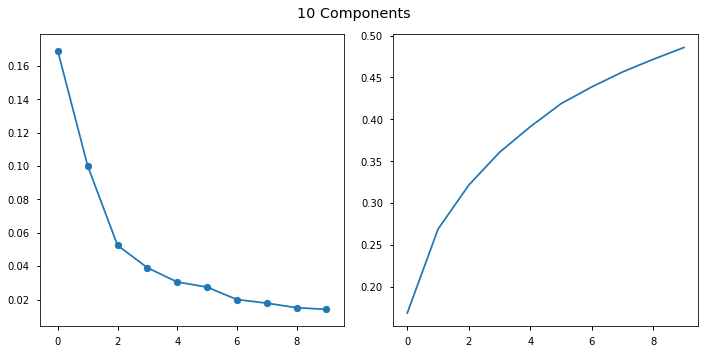

In [140]:
_ = _pca(X)

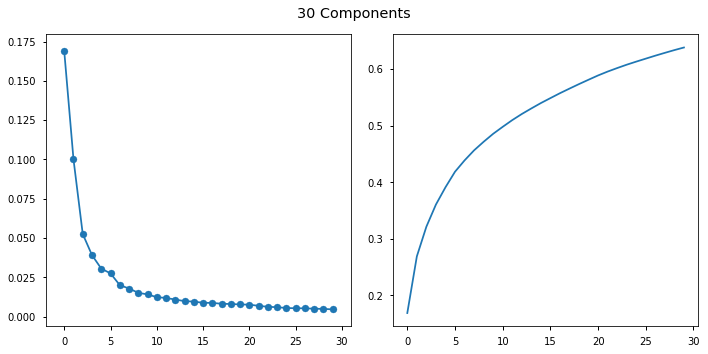

In [141]:
_ = _pca(X, 30)

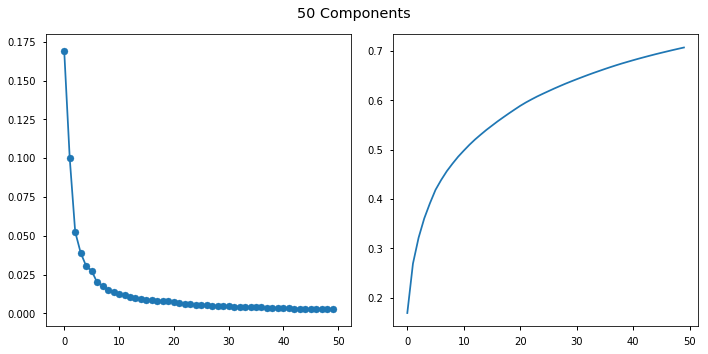

In [142]:
pca = _pca(X, 50)

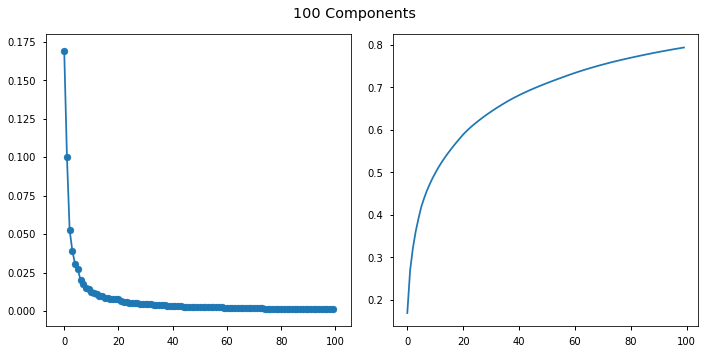

In [143]:
_ = _pca(X, 100)

In [144]:
# What about using non z-scores

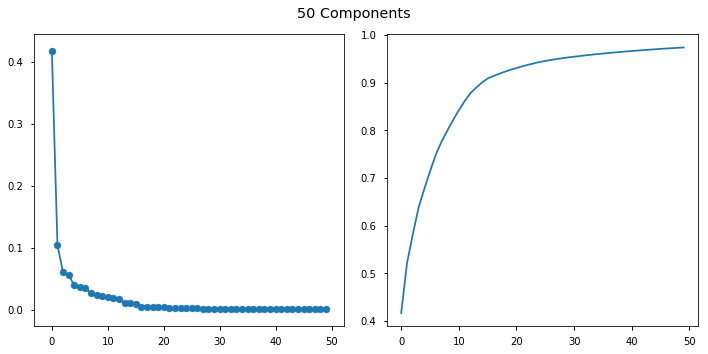

In [145]:
pca = _pca(norm.T, 50)

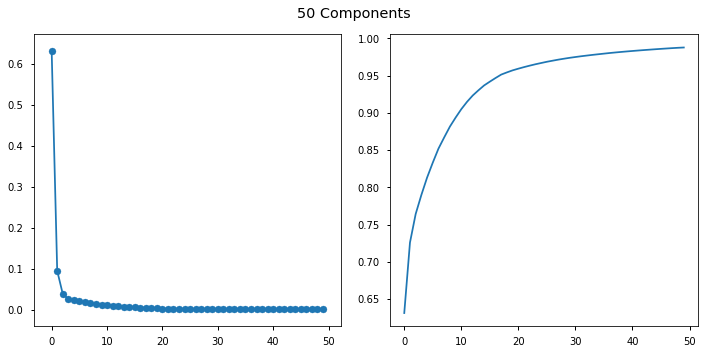

In [146]:
_ = _pca(df.T, 50)

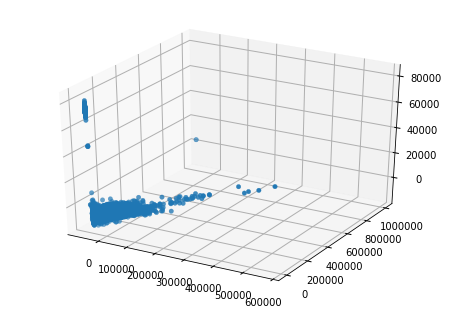

In [147]:
X_pca = pca.transform(norm.T)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])

In [148]:
# Lets look at other features

In [42]:
# Figure out strand >= 0.95
from ncbi_remap.prealn_wf import strandedness, STRAND_CUTOFF2
fs, sc, un = strandedness(store, cutoff=STRAND_CUTOFF2)

#first = fb[fb.srr.isin(fs.srr)]
#second = fb[fb.srr.isin(sc.srr)]

# Import picard results by strand
#srrs = first.srr.tolist()
srrs = fs.srr.tolist()
picard1 = store.select('prealn/workflow/collectrnaseqmetrics/first', 'srr == srrs')

#srrs = second.srr.tolist()
srrs = sc.srr.tolist()
picard2 = store.select('prealn/workflow/collectrnaseqmetrics/second', 'srr == srrs')

srrs = un.srr.tolist()
picard3 = store.select('prealn/workflow/collectrnaseqmetrics/unstranded', 'srr == srrs')

# merge picard results
picard = pd.concat([picard1, picard2, picard3])

In [43]:
features = picard[[
    'PCT_CODING_BASES', 'PCT_INTERGENIC_BASES', 'PCT_INTRONIC_BASES', 'PCT_MRNA_BASES',
       'PCT_UTR_BASES'
]]

In [45]:
scaler = StandardScaler()
scaled = scaler.fit_transform(features)
pca = PCA(n_components=3).fit(scaled)
X_pca = pca.transform(scaled)

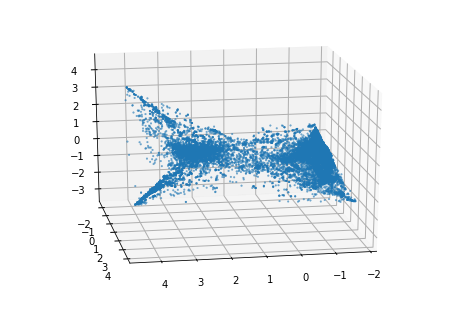

In [46]:
fig = plt.figure()
ax = Axes3D(fig, elev=20, azim=80)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], alpha=.6, s=3)

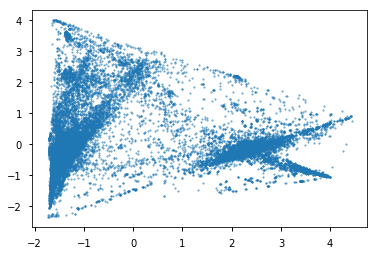

In [47]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=.6, s=3)

In [49]:
from sklearn.cluster import KMeans
pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('cluster', KMeans(n_clusters=20))
])

In [50]:
pipe.fit(features)

Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('cluster', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [51]:
cluster = pipe.named_steps['cluster']

In [52]:
cluster.labels_

array([12, 12, 12, ..., 10,  1, 19], dtype=int32)

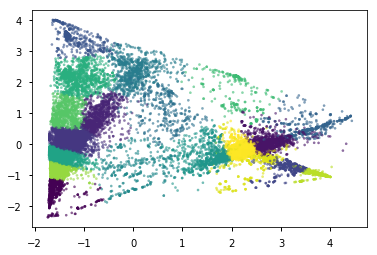

In [55]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster.labels_, s=5, alpha=.6)

In [56]:
from sklearn.manifold import TSNE

In [57]:
tsne = TSNE()

In [58]:
Y = tsne.fit_transform(X_pca)

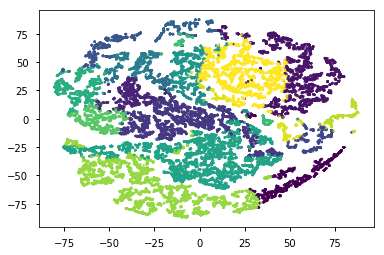

In [59]:
plt.scatter(Y[:, 0], Y[:, 1], c=cluster.labels_, s=5, alpha=.8)

In [60]:
features.head()

,,PCT_CODING_BASES,PCT_INTERGENIC_BASES,PCT_INTRONIC_BASES,PCT_MRNA_BASES,PCT_UTR_BASES
srx,srr,,,,,
SRX2556775,SRR5251041,0.274245,0.041728,0.020262,0.938011,0.663765
SRX2556774,SRR5251040,0.198718,0.053333,0.039478,0.907189,0.708471
SRX2556773,SRR5251039,0.264752,0.047652,0.027478,0.924870,0.660118
SRX2556772,SRR5251038,0.261292,0.044095,0.029205,0.926701,0.665408
SRX2556771,SRR5251037,0.235087,0.049550,0.029990,0.920461,0.685373


In [64]:
dat.set_index('srx', inplace=True)

In [80]:
strat = dat.loc[features.index.get_level_values(0), 'library_strategy']

In [70]:
categories = dat.library_strategy.value_counts().index.tolist()

In [72]:
mapper = {k: v for k, v in zip(categories, range(len(categories)))}

In [121]:
rev = {v: k for k, v in mapper.items()}

In [73]:
colors = strat.map(lambda x: mapper[x]).values

In [146]:
cmap = sns.color_palette('tab20', n_colors=len(categories))

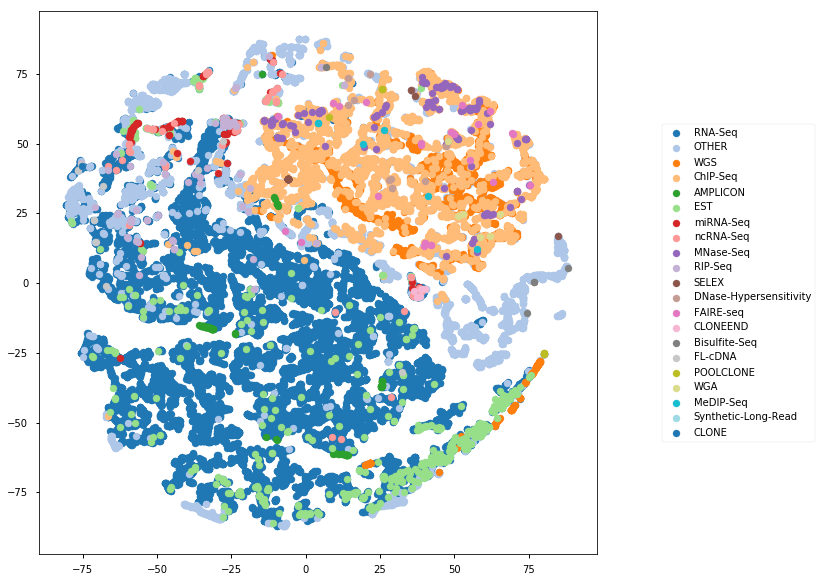

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for n in range(len(categories)):
    idx = np.argwhere(colors == n)
    ax.scatter(Y[idx, 0], Y[idx, 1], c=cmap[n], s=50, label=rev[n])
plt.legend(loc=7, bbox_to_anchor=(1.4, .5))